# Compare correlations of gene-reaction pairs in intersection of Gerosa and Ishii

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [2]:
#import self-made functions
%run '/Users/mariekececilia/Documents/master_thesis_code/methods.ipynb'

In [3]:
#figure saving settings for this Notebook
folder_path_figures = 'Figures/'
figure_format = 'pdf'

In [4]:
#update math text font to match latex
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Charter' #same font as in Latex document
plt.rcParams['mathtext.it'] = 'Serif:italic' #closest to Latex font (couldn't find Charter italic font)
plt.rcParams['mathtext.bf'] = 'Serif:bold' #cloeset to Latex font (couldn't find Charter bold font)

## Load, clean and prepare data

Load data, split ishii into growth rate and knock-out set (both containing the baseline WT at 0.2h-1):

In [5]:
#load data
gexp_g, flux_g = load_gerosa()
gexp_i, flux_i = load_ishii()

#split ishii
gexp_i_gr, gexp_i_ko = split_ishii(gexp_i)
flux_i_gr, flux_i_ko = split_ishii(flux_i) 

Clean data (remove columns):

In [6]:
#remove duplicated genes, only relevant for Gerosa:
gexp_g, _ = clean_gexp_g(gexp_g)

#remove constant reactions, external reactions and reactions with many null entries
flux_g = remove_ex_constant_zero(flux_g)
flux_i_gr = remove_ex_constant_zero(flux_i_gr)
flux_i_ko = remove_ex_constant_zero(flux_i_ko)

#remove duplicates that they agree on (identified in 'removed_columns' Notebook)
#here it is only removed from ishii, will find intersection later and then it will be reomved from gerosa too
common_duplicates_gr = ['R_ACONTb', 'R_CS', 'R_SUCOAS', 'R_PGM', 'R_PGL', 'R_PGK', 'R_TKT1']
common_duplicates_ko = ['R_ACONTb', 'R_CS', 'R_SUCOAS', 'R_PGM', 'R_PGK', 'R_MALS', 'R_TKT1']
flux_i_gr = flux_i_gr.drop(common_duplicates_gr, axis = 1)
flux_i_ko = flux_i_ko.drop(common_duplicates_ko, axis = 1)

Convert fluxes to absolute fluxes because amount of required enzyme is independent of flux direction:

In [7]:
flux_g = flux_g.abs()
flux_i_gr = flux_i_gr.abs()
flux_i_ko = flux_i_ko.abs() 

## Calculate correlations in intersection

In [8]:
#get intersection of genes before calculating correlations to avoid unnecessary computation of all 4k + genes in Gerosa
intersection_genes = get_intersection(gexp_g, gexp_i)

#calculate correlations between all gene-reaction pairs
corr_g = get_all_correlations(gexp_g[intersection_genes], flux_g, column_names = ['gene', 'reaction', 'r'])
corr_i_gr = get_all_correlations(gexp_i_gr, flux_i_gr, column_names = ['gene', 'reaction', 'r'])
corr_i_ko = get_all_correlations(gexp_i_ko, flux_i_ko, column_names = ['gene', 'reaction', 'r'])

#merge results of pairs in both Gerosa and Ishii (intersection)
corr_gr = pd.merge(corr_g, corr_i_gr, on=['gene', 'reaction'], suffixes = ('_g', '_i'))
corr_ko = pd.merge(corr_g, corr_i_ko, on=['gene', 'reaction'], suffixes = ('_g', '_i'))

## Prepare for plotting

Add and format columns:

In [9]:
#remove R_ for nicer figures:
corr_gr['reaction'] = corr_gr['reaction'].map(lambda x: x[2:])
corr_ko['reaction'] = corr_ko['reaction'].map(lambda x: x[2:])

#add columns to use absolute value if wanted
corr_gr['r_g_abs'] = corr_gr['r_g'].abs()
corr_gr['r_i_abs'] = corr_gr['r_i'].abs()

corr_ko['r_g_abs'] = corr_ko['r_g'].abs()
corr_ko['r_i_abs'] = corr_ko['r_i'].abs()

#add columns to highlight high and low correlations if wanted
high = 0.5
corr_gr['g_label'] = corr_gr['r_g_abs'].map(lambda x: 'high' if x>= 0.5 else 'low')
corr_gr['i_label'] = corr_gr['r_i_abs'].map(lambda x: 'high' if x>= 0.5 else 'low')
corr_gr['gerosa|ishii'] = corr_gr['g_label'] + ' - ' + corr_gr['i_label']

corr_ko['g_label'] = corr_ko['r_g_abs'].map(lambda x: 'high' if x>= 0.5 else 'low')
corr_ko['i_label'] = corr_ko['r_i_abs'].map(lambda x: 'high' if x>= 0.5 else 'low')
corr_ko['gerosa|ishii'] = corr_ko['g_label'] + ' - ' + corr_ko['i_label']

### Differences in legend

In [10]:
print('Only in KO:', set(corr_ko['reaction'].tolist()).difference(set(corr_gr['reaction'].tolist())))
print('Only in GR:', set(corr_gr['reaction'].tolist()).difference(set(corr_ko['reaction'].tolist())))

Only in KO: {'PGL', 'ICL'}
Only in GR: set()


PGL and ICL is in Ishii KO - Gerosa intersection, but not in Ishii GR - Gerosa intersection (because duplicated in both or not enough non-null-entries in the Ishii subset). To use the same color coding of reactions in the two plots, Ishii GR - Gerosa plot need to use the same palette as the other, but where the colors that would map to PGL and ICL are skipped:

In [11]:
from matplotlib import cm
from matplotlib.colors import rgb2hex

#get colors from palette
colors = []
cmap = cm.get_cmap('tab20', 20)
for i in range(cmap.N):
    rgba = cmap(i)
    colors.append(rgb2hex(rgba))

#Rows are sorted by reaction before plotting, so that the legend is sorted.
#Therefore, need to find the index of ICL and PGL in the sorted list of unique reactions
skip_index_1 = corr_ko['reaction'].sort_values().unique().tolist().index('ICL')
skip_index_2 = corr_ko['reaction'].sort_values().unique().tolist().index('PGL')

colors = colors[:skip_index_1] + colors[skip_index_1+1:skip_index_2] + colors[skip_index_2+1:]

## Plotting

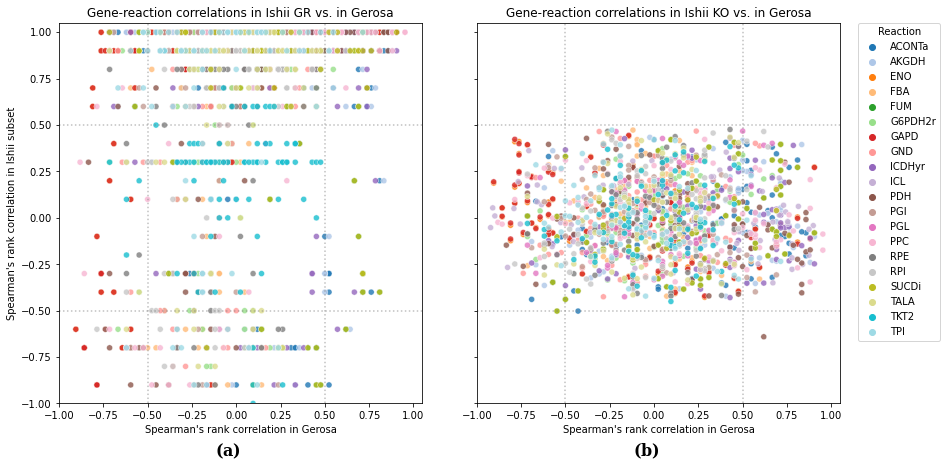

In [12]:
#-------------------- Settings ----------------------------------------------------------
figure_name = 'corr_vs_corr'
suptitle = 'Correlations of gene-reaction pairs in the intersection of Ishii and Gerosa data'

hue = 'reaction'
legend_title = 'Reaction'
palette = colors

datasets = [corr_gr.sort_values(by = hue),
            corr_ko.sort_values(by = hue)]
palettes = [colors, 
            'tab20']
titles = ['Gene-reaction correlations in Ishii GR vs. in Gerosa',
          'Gene-reaction correlations in Ishii KO vs. in Gerosa',]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7),sharex=True, sharey=True,)

#-------------------- Actual plotting --------------------------------------------------
for ax, data, palette, title in zip(axes, datasets, palettes, titles):
    sns.scatterplot(x='r_g', 
                    y='r_i',
                    hue = hue,
                    palette = palette,
                    data = data,
                    alpha = 0.8,
                    ax = ax
                   )
    ax.hlines([-0.5, 0.5], -1, 1.05, colors = ['grey'], linestyles = 'dotted', alpha = 0.5)
    ax.vlines([-0.5, 0.5], -1, 1.05, colors = ['grey'], linestyles = 'dotted', alpha = 0.5)
    ax.set_xlim(-1,1.05)
    ax.set_ylim(-1,1.05)
    ax.set_xlabel("Spearman's rank correlation in Gerosa")
    ax.set_ylabel("Spearman's rank correlation in Ishii subset")
    ax.set_title(title)
    ax.get_legend().remove()
    
#-------------------- Number the plots --------------------------------------------------
#add plot numbering
plot_numbers = [r'$\bf{(a)}$',
                r'$\bf{(b)}$',
               ]
plot_captions = ['','','','','','',''] #when info in titles instead of cpations
for ax, plot_number, plot_caption in zip(fig.axes, plot_numbers, plot_captions):
    ax.text(.43, -.1, 
            plot_number + ' ' + plot_caption, 
            transform=ax.transAxes,
            fontsize=16, 
            family = 'serif',
            fontname = 'Charter',
            va='top',
            #fontweight = 'bold',
           )
    
#---------------------- Add legend and title --------------------------------------------
axes[1].legend(bbox_to_anchor=(1.05, 1), 
           loc=2, 
           borderaxespad=0., 
           title = legend_title, 
           ncol = 1)
#plt.suptitle(suptitle, weight = 'bold')
plt.subplots_adjust(wspace=0.15, hspace=0.4) #width and height between subplots
    
#---------------------- Save figure -----------------------------------------------------
plt.savefig(('%s%s.%s' % (folder_path_figures, figure_name, figure_format)), 
        format=figure_format, 
        dpi=200,
        bbox_inches = 'tight', #include the legend
        facecolor = 'white',
     )
plt.show()
plt.close()

### Reactions with the same correlations

Reactions that have the same r_g and r_i for all genes even though they are not duplicated in both datasets.

In [13]:
for corr, name in zip([corr_gr, corr_ko], ['GR intersection', 'KO intersection']):
    #find set of reactions with the same gene, r_g and r_i                  
    grouped = (corr.groupby(['gene', 'r_g', 'r_i']).agg({'reaction':set}))
    
    #find rows with sets of more than one reaction
    same = grouped.iloc[:,0].map(lambda x: True if len(x)>1 else False)
    
    #extract all sets of more than one reaction
    groups = grouped[same].iloc[:,0].tolist()
    groups = [sorted(x) for x in groups] #sort all sets so that tuples of the same elements are considered equal (the order matter)
    groups = [tuple(x) for x in groups] #convert sets to tuples to allow next steps
    
    #split groups of more than two reactions into several groups, one per combination
    import itertools
    splitted = []
    for group in groups:
        combos = list(itertools.combinations(group, 2))
        for combo in combos:
            splitted.append(combo)
    splitted = [sorted(x) for x in splitted]
    splitted = [tuple(x) for x in splitted]
    
    #count the occurences of groups
    from collections import Counter
    counts = Counter(elem for elem in splitted)
    
    #find groups that occur as many times as there are unique genes 
    print('These reactions will always plot on top of each other in the', name)
    for k,v in counts.items():
        if (v == corr['gene'].nunique()):
            print(k)
    print()

These reactions will always plot on top of each other in the GR intersection
('ENO', 'GAPD')
('FUM', 'SUCDi')

These reactions will always plot on top of each other in the KO intersection
('FUM', 'SUCDi')

